# Factorial Hidden Markov Model (FHMM) using Lab Data
- This notebook is written to use the **FHMM algorithm** to train a model using our lab data
- This allows us to use only the **power dataframe in MultiIndex format** instead of the MeterGroup format from NILMTK to use the algorithm's functions

**Training dataset**
- Model is trained using kettle+vacuum 8 mins data
    - Expected to be able to detect kettle and vacuum classification
    
**Training module steps:**
1. Gaussian HMM
2. EM Algorithm
3. Combine FHMM
4. Viterbi Algorithm (Find most likely state sequence)
5. Decode HMM state sequence

**Testing dataset:**
1. Disaggregation will be using kettle+vacuum 6 mins data
    - Expected that it will be able to classify these 2 appliances properly
    
**Disaggregation module steps:**
1. Import trained model
4. Predicted vs ground truth comparison
5. Evaluation

Note: The headings represents the function names found in NILMTK algorithm code

In [1]:
# Importing libraries for working with DataFrames and visualizations
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
import warnings
import time

# For evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Importing the following for working with NILM dataset
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.utils import print_dict
from nilmtk.api import API

# FHMM functions
#from nilmtk.legacy.disaggregate import fhmm_exact
from nilmtk.feature_detectors import cluster
from nilmtk.disaggregate import Disaggregator, FHMMExact
from nilmtk.datastore import HDFDataStore
from hmmlearn import hmm

# for Partial Fit
from nilmtk.disaggregate.fhmm_exact import sort_learnt_parameters, create_combined_hmm
from collections import OrderedDict

#plt.style.use('ggplot')
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
# Global variables #
# For API functions
appliances = ["kettle","vacuum"]
train_submeters = []
train_mains = []
test_submeters = []
test_mains = pd.DataFrame()
gt_overall = {}
pred_overall = {}
classifiers=[]
errors = []
errors_keys = []

# For fhmm functions
model = []
MODEL_NAME = 'FHMMExact'


power = 'active'

metrics = ['mae', 'rmse', 'f1score']
sample_period = 1

In [4]:
#initiate fhmm
obj_fhmm = FHMMExact({'num_of_states':2})

# Dataset preparation - Training
Changing lab power data into df that can feed into NILMTK function

- Data     : kettle + vacuum: has main, kettle, vacuum load data
- Frequency: 1Hz
- Duration : 8 mins
- Pattern: Multiple on/off states

In [5]:
def get_multiIndex(appliance_df, columns):
    df_app = pd.DataFrame(appliance_df['Active (W)'])
    df_app.columns = columns
    df_app.columns.names = ['physical_quantity', 'type']
    df_app.index = pd.to_datetime(df_app.index)
    df_app.index.name = None
    return df_app

In [6]:
# Main load df
main_df=pd.read_csv("../Lab_Dataset/2combi_kettle+vacuum/train_data/main.csv", index_col=0)

# Load submeters
kettle_df=pd.read_csv("../Lab_Dataset/2combi_kettle+vacuum/train_data/kettle.csv", index_col=0)
vacuum_df=pd.read_csv("../Lab_Dataset/2combi_kettle+vacuum/train_data/vacuum.csv", index_col=0)

main_df

RMS Current  Average Current  Peak Current  Apparent (W)  \
Timestamp                                                                       
2022-11-14 16:42:33         0.01              0.0          0.01          2.07   
2022-11-14 16:42:34         0.01              0.0          0.01          2.93   
2022-11-14 16:42:35         0.01              0.0          0.01          2.69   
2022-11-14 16:42:36         0.01              0.0          0.02          2.96   
2022-11-14 16:42:37         0.01              0.0          0.01          2.57   
...                          ...              ...           ...           ...   
2022-11-14 16:50:50         0.01              0.0          0.02          1.98   
2022-11-14 16:50:51         0.01              0.0          0.00          1.82   
2022-11-14 16:50:52         0.01              0.0          0.02          2.39   
2022-11-14 16:50:53         0.01              0.0          0.02          2.36   
2022-11-14 16:50:54         0.01              0.0          0.02          2.21   

                     Active (W)  Reactive (W)  Power Factor  \
Timestamp                                                     
2022-11-14 16:42:33        0.39          2.03      0.188766   
2022-11-14 16:42:34        0.50          2.88      0.170425   
2022-11-14 16:42:35        0.45          2.65      0.165865   
2022-11-14 16:42:36        0.45          2.92      0.152661   
2022-11-14 16:42:37        0.51          2.52      0.198059   
...                         ...           ...           ...   
2022-11-14 16:50:50        0.34          1.95      0.171031   
2022-11-14 16:50:51        0.31          1.79      0.169447   
2022-11-14 16:50:52        0.40          2.36      0.166743   
2022-11-14 16:50:53        0.38          2.33      0.161546   
2022-11-14 16:50:54        0.41          2.17      0.186756   

                     Fundamental Frequency (50Hz)  Third Harmonics (150Hz)  \
Timestamp                                                                    
2022-11-14 16:42:33                           0.0                      0.0   
2022-11-14 16:42:34                           0.0                      0.0   
2022-11-14 16:42:35                           0.0                      0.0   
2022-11-14 16:42:36                           0.0                      0.0   
2022-11-14 16:42:37                           0.0                      0.0   
...                                           ...                      ...   
2022-11-14 16:50:50                           0.0                      0.0   
2022-11-14 16:50:51                           0.0                      0.0   
2022-11-14 16:50:52                           0.0                      0.0   
2022-11-14 16:50:53                           0.0                      0.0   
2022-11-14 16:50:54                           0.0                      0.0   

                     Fifth (250Hz)  Seventh (350Hz)  Ninth (450Hz)  
Timestamp                                                           
2022-11-14 16:42:33            0.0              0.0            0.0  
2022-11-14 16:42:34            0.0              0.0            0.0  
2022-11-14 16:42:35            0.0              0.0            0.0  
2022-11-14 16:42:36            0.0              0.0            0.0  
2022-11-14 16:42:37            0.0              0.0            0.0  
...                            ...              ...            ...  
2022-11-14 16:50:50            0.0              0.0            0.0  
2022-11-14 16:50:51            0.0              0.0            0.0  
2022-11-14 16:50:52            0.0              0.0            0.0  
2022-11-14 16:50:53            0.0              0.0            0.0  
2022-11-14 16:50:54            0.0              0.0            0.0  

[502 rows x 12 columns]

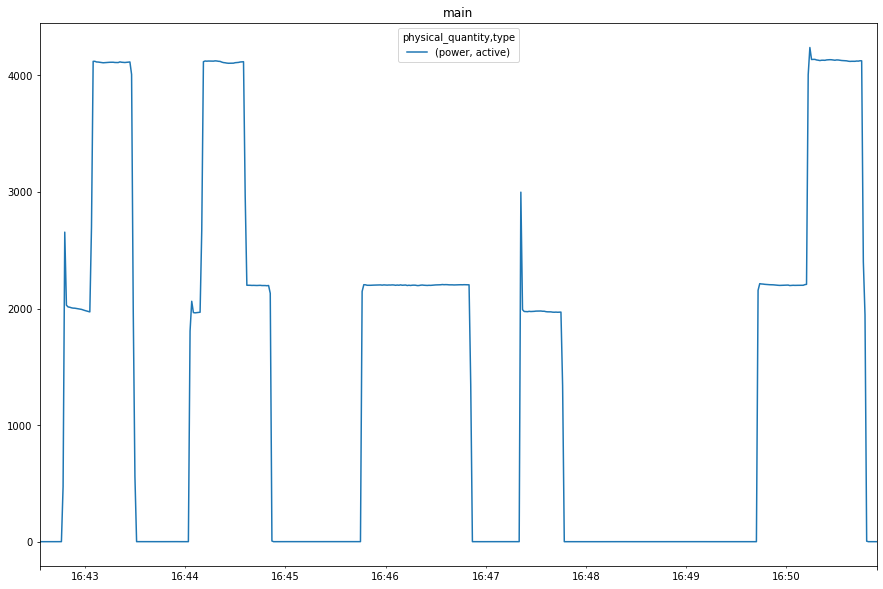

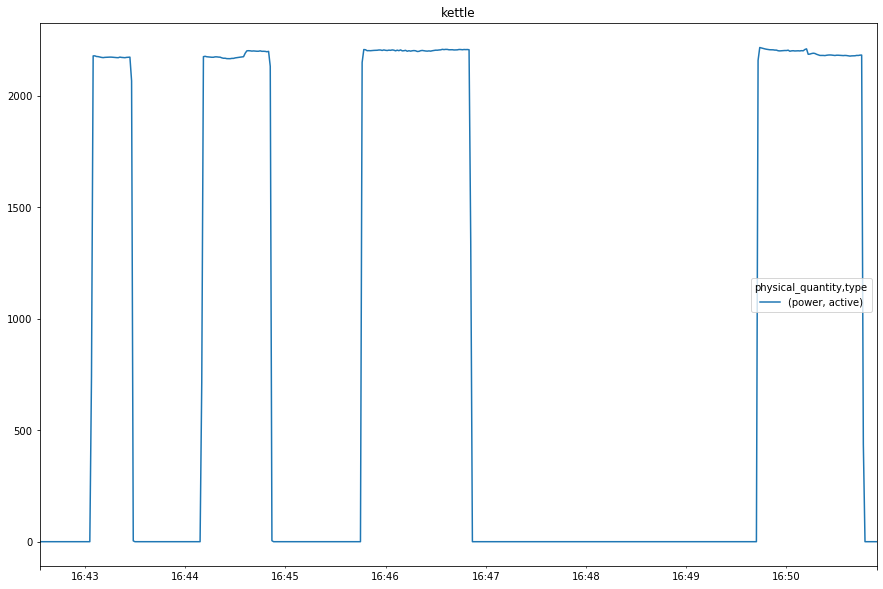

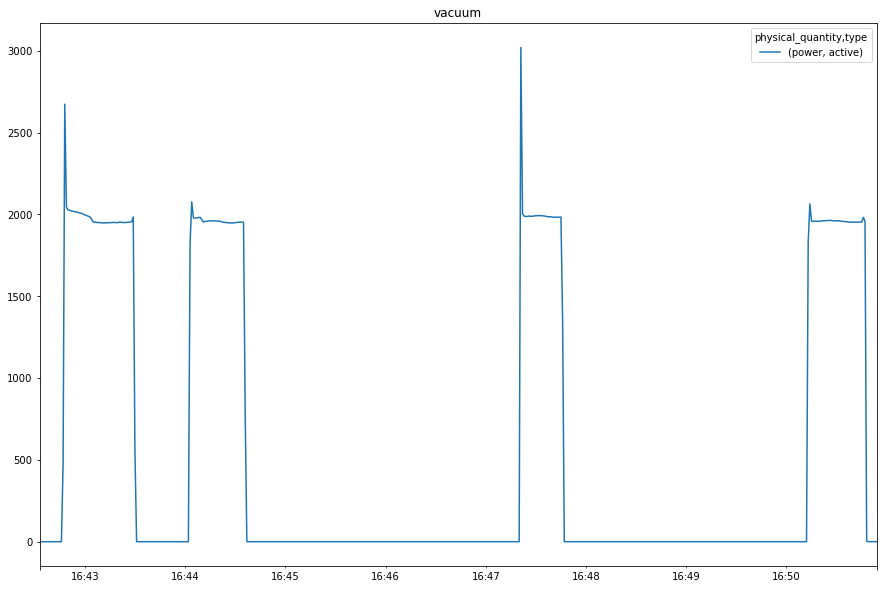

In [7]:
# Convert lab data to multiIndex df
# set column
columns = pd.MultiIndex.from_tuples([('power','active')])

# main
df_main = get_multiIndex(main_df, columns)
# Kettle
df_ke = get_multiIndex(kettle_df, columns)
# Vacuum
df_vac = get_multiIndex(vacuum_df, columns)

df_main.plot(title='main')
df_ke.plot(title='kettle')
df_vac.plot(title='vacuum')

In [8]:
# Finding mean of steady state values
print("Kettle mean:\n",df_ke.replace(0, np.NaN).mean())
print("Vacuum mean:\n",df_vac.replace(0, np.NaN).mean())

Kettle mean:
 physical_quantity  type  
power              active    2141.802412
dtype: float64
Vacuum mean:
 physical_quantity  type  
power              active    1933.210143
dtype: float64


In [9]:
# Append appliances into one list
appliance_readings = []
appliance_readings.append(df_ke)
appliance_readings.append(df_vac)

In [10]:
# Aggregated load is already in mains, no need to artificial aggregate
train_df = df_main
train_submeters = [[] for i in range(len(appliances))]
train_mains = []

train_mains.append(train_df)
for i,name in enumerate(appliances):
    train_submeters[i].append(appliance_readings[i])

appliance_readings = []
for i,appliance_name in enumerate(appliances):
    appliance_readings.append((appliance_name, train_submeters[i]))

train_submeters = appliance_readings 

# Training
Extracting code from NILMTK API and FHMM to use for lab data

## Partial Fit
FHMM partial fit function
1. Estimates model parameters using EM algorithm
    - Sets the stmc parameters
        - S: Start probability
        - T: Transition matrix
        - M: Means
        - C: Covariance matrix
    - Means value is the mean power draw of appliances in steady state/on state
2. Create combined HMM model by using __[Kronecker product](https://www.statlect.com/matrix-algebra/Kronecker-product)__ to combine the individual model's parameters
    - Combined means is by the appliances' combination of states

In [11]:
def partial_fit(train_main, train_appliances):
    """
    Train using 1d FHMM.
    """
    print(".........................FHMM partial_fit.................")

    train_main = pd.concat(train_main, axis=0)
    train_app_tmp = []

    for app_name, df_list in train_appliances:
        df_list = pd.concat(df_list, axis=0)
        train_app_tmp.append((app_name,df_list))
        obj_fhmm.app_names.append(app_name)

    print (train_main.shape)

    train_appliances = train_app_tmp

    learnt_model = OrderedDict()
    num_meters = len(train_appliances)
    if num_meters > 12:
        max_num_clusters = 2
    else:
        max_num_clusters = 3

    for appliance, meter in train_appliances:
            
        meter_data = meter.dropna()
        X = meter_data.values.reshape((-1, 1))
            
        if not len(X):
            print("Submeter '{}' has no samples, skipping...".format(meter))
            continue
                
        assert X.ndim == 2
        obj_fhmm.X = X

        if obj_fhmm.num_of_states > 0:
            # User has specified the number of states for this appliance
            num_total_states = obj_fhmm.num_of_states

        else:
            # Find the optimum number of states
            states = cluster(meter_data, max_num_clusters)
            num_total_states = len(states)

        print("\nTraining model for submeter '{}'".format(appliance))
        # GaussianHMM in hmm.py
        learnt_model[appliance] = hmm.GaussianHMM(num_total_states, "full")
        print("Model for " + appliance + " initiated: ", learnt_model[appliance])

        # Fit in base.py
        print("Estimating model parameters (fit)...")
        learnt_model[appliance].fit(X)
        print("Trained model for : " + appliance)

        # Check to see if there are any more chunks.
        # TODO handle multiple chunks per appliance.

    # Combining to make a AFHMM
    obj_fhmm.meters = []
    new_learnt_models = OrderedDict()
    print("\n-----Individual models-----")
    for meter in learnt_model:
        print("\n",meter)
        # sort_learnt_parameters in fhmm_exact.py
        startprob, means, covars, transmat = sort_learnt_parameters(
            learnt_model[meter].startprob_, learnt_model[meter].means_,
            learnt_model[meter].covars_, learnt_model[meter].transmat_)
                
        new_learnt_models[meter] = hmm.GaussianHMM(startprob.size, "full")
        new_learnt_models[meter].startprob_ = startprob
        new_learnt_models[meter].transmat_ = transmat
        new_learnt_models[meter].means_ = means
        new_learnt_models[meter].covars_ = covars
        
        print("startprob_:\n",new_learnt_models[meter].startprob_)
        print("transmat_:\n",new_learnt_models[meter].transmat_)
        print("means_:\n",new_learnt_models[meter].means_)
        
        # UGLY! But works.
        obj_fhmm.meters.append(meter)
        
    print("\nCombining parameters using Kronecker product...")
    # create_combined_hmm in fhmm_exact.py
    learnt_model_combined = create_combined_hmm(new_learnt_models)
    obj_fhmm.individual = new_learnt_models
    obj_fhmm.model = learnt_model_combined

    print("Combined Model ",obj_fhmm.model, " parameters:")
    print("startprob_:\n",obj_fhmm.model.startprob_)
    print("transmat_:\n", obj_fhmm.model.transmat_)
    print("means_:\n",obj_fhmm.model.means_)
    
    print("\n.........................FHMM partial_fit end.........................")

In [12]:
#Start training
start_time = time.time()

partial_fit(train_mains,train_submeters)

print("--- Runtime: %s seconds ---" % (time.time() - start_time))

.........................FHMM partial_fit.................
(502, 1)

Training model for submeter 'kettle'
Model for kettle initiated:  GaussianHMM(covariance_type='full', n_components=2)
Estimating model parameters (fit)...
Trained model for : kettle

Training model for submeter 'vacuum'
Model for vacuum initiated:  GaussianHMM(covariance_type='full', n_components=2)
Estimating model parameters (fit)...
Trained model for : vacuum

-----Individual models-----

 kettle
startprob_:
 [1.00000000e+000 8.92129233e-153]
transmat_:
 [[0.98675497 0.01324503]
 [0.0201005  0.9798995 ]]
means_:
 [[   0.        ]
 [2141.80241206]]

 vacuum
startprob_:
 [1.00000000e+00 3.45618715e-73]
transmat_:
 [[0.98891967 0.01108033]
 [0.02857143 0.97142857]]
means_:
 [[   0.        ]
 [1933.21014286]]

Combining parameters using Kronecker product...
Combined Model  GaussianHMM(covariance_type='full', n_components=4)  parameters:
startprob_:
 [1.00000000e+000 3.45618715e-073 8.92129233e-153 3.08336559e-225]
tran

In [13]:
# centroid/states saved to model dict
obj_fhmm.model

GaussianHMM(covariance_type='full', n_components=4)

Observation:
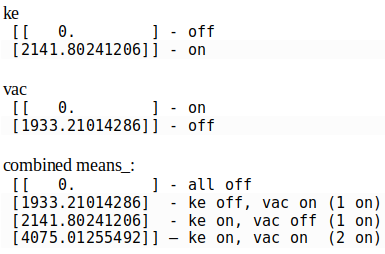

Means values get from mean steady state of each appliances
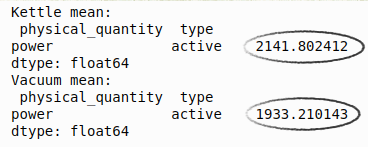

## Export model

In [14]:
def export_model(filename):
    example_dict = obj_fhmm.model
    with open(filename, "wb") as pickle_out:
        pickle.dump(example_dict, pickle_out)

In [15]:
export_model('trained_model/modelTrainedFHMM_ke+vac.pickle')

# Dataset preparation - Testing
Changing lab power data into df that can feed into NILMTK 

- Data     : kettle + vacuum: has main, kettle, vacuum load data
- Frequency: 1Hz
- Duration : 6 mins
- Data type: active power only

In [16]:
# Main load df
main_df=pd.read_csv("../Lab_Dataset/2combi_kettle+vacuum/test_data/main._output.csv", index_col=0)
# Load submeters
kettle_df=pd.read_csv("../Lab_Dataset/2combi_kettle+vacuum/test_data/kettle._output.csv", index_col=0)
vacuum_df=pd.read_csv("../Lab_Dataset/2combi_kettle+vacuum/test_data/vacuum._output.csv", index_col=0)

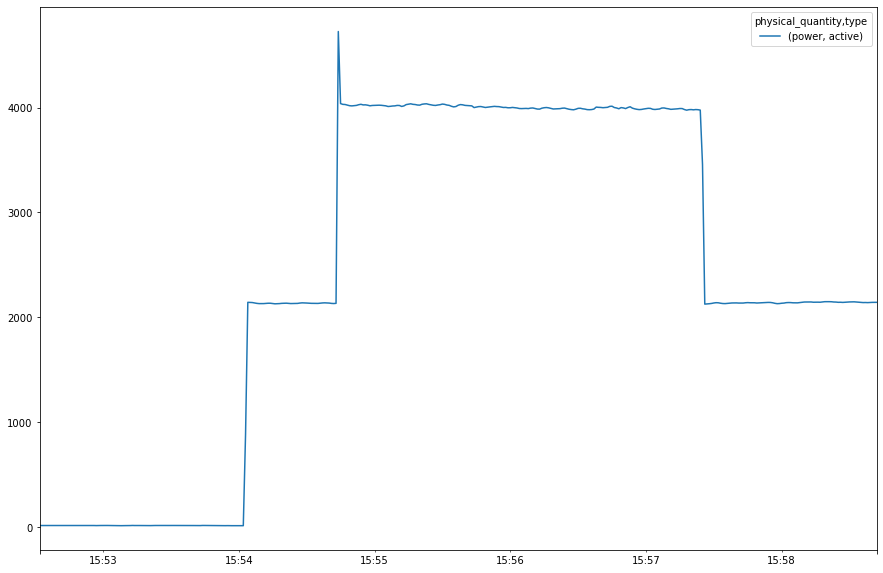

In [17]:
# Convert lab data to multiIndex df
# set column
columns = pd.MultiIndex.from_tuples([('power','active')])

# main
df_main = get_multiIndex(main_df, columns)
# Kettle
df_ke = get_multiIndex(kettle_df, columns)
# Vacuum
df_vac = get_multiIndex(vacuum_df, columns)

df_main
df_main.plot()

In [18]:
# Append appliances into one list
appliance_readings = []
appliance_readings.append(df_ke)
appliance_readings.append(df_vac)

# Aggregated load is already in mains, no need to artificial aggregate
test_df = df_main

test_submeters = [[] for i in range(len(appliances))]
test_mains = []

test_mains.append(test_df)
for i,name in enumerate(appliances):
    test_submeters[i].append(appliance_readings[i])

appliance_readings = []
for i,appliance_name in enumerate(appliances):
    appliance_readings.append((appliance_name, test_submeters[i]))

test_submeters = appliance_readings 

In [19]:
df_main

physical_quantity      power
type                  active
2022-09-27 15:52:32    16.25
2022-09-27 15:52:33    16.54
2022-09-27 15:52:34    16.42
2022-09-27 15:52:35    16.38
2022-09-27 15:52:36    16.50
...                      ...
2022-09-27 15:58:38  2140.91
2022-09-27 15:58:39  2142.35
2022-09-27 15:58:40  2143.27
2022-09-27 15:58:41  2143.21
2022-09-27 15:58:42  2143.65

[371 rows x 1 columns]

# Testing


## Import model

In [20]:
def import_model(filename):
    with open(filename, "rb") as pickle_in:
        model = pickle.load(pickle_in)
        #states = model['states']
        #appliance_name = model['appliance_name']
    return model

In [21]:
model = import_model('trained_model/modelTrainedFHMM_ke+vac.pickle')

pred_overall={}
gt_overall={} 

obj_fhmm.model = model

## Predict function
- The overall predict function to run the  main processes for disaggregation
- Generates predictions on the test dataset using the specified classifier
- Main processes:
    1. Model predict
    2. HMM decode

In [22]:
def predict(test_mains, test_submeters):
    print ("Generating predictions for :",MODEL_NAME)        

    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.   
    # disag_chunk call
    pred_list = disaggregate_chunk(test_mains)

    # It might not have time stamps sometimes due to neural nets
    # It has the readings for all the appliances

    concat_pred_df = pd.concat(pred_list,axis=0)

    gt = {}
    for meter,data in test_submeters:
        concatenated_df_app = pd.concat(data,axis=1)
        index = concatenated_df_app.index
        gt[meter] = pd.Series(concatenated_df_app.values.flatten(),index=index)

    gt_overall = pd.DataFrame(gt, dtype='float32')
    pred = {}

    for app_name in concat_pred_df.columns:
        app_series_values = concat_pred_df[app_name].values.flatten()
        # Neural nets do extra padding sometimes, to fit, so get rid of extra predictions
        app_series_values = app_series_values[:len(gt_overall[app_name])]
        pred[app_name] = pd.Series(app_series_values, index = gt_overall.index)
    pred_overall = pd.DataFrame(pred,dtype='float32')
        
    print("\ngt_overall:\n", gt_overall)
    print("pred_overall:\n", pred_overall)
    return gt_overall, pred_overall

## Disaggregate chunk function in FHMM
- Disaggregate the test data according to the model learnt previously
- Performs 1D FHMM disaggregation

Internal process:
1. Model Predict - Find most likely sequence os states corresponding to aggregated sample

In [23]:
def disaggregate_chunk(test_mains_list):
    print ("\n---disaggregate_chunk---")

    # Array of learnt states
    test_prediction_list = []

    for test_mains in test_mains_list:
            
        learnt_states_array = []
        if len(test_mains) == 0:
            tmp = pd.DataFrame(index = test_mains.index, columns = obj_fhmm.app_names)
            test_prediction_list.append(tmp)
        else:
            length = len(test_mains.index)
            temp = test_mains.values.reshape(length, 1)
            print("model prediction...")
            print("Finding most likely state sequence corresponding to aggregated test data")
            print("-using Viterbi algorithm")
            # decode funct in base.py
            learnt_states_array.append(obj_fhmm.model.predict(temp))

            # Model
            means = OrderedDict()
            for elec_meter, obj_fhmm.model in obj_fhmm.individual.items():
                means[elec_meter] = (
                    obj_fhmm.model.means_.round().astype(int).flatten().tolist())
                means[elec_meter].sort()

            decoded_power_array = []
            decoded_states_array = []

            for learnt_states in learnt_states_array:
                print("parameters put into decode function:")
                print("means/centroids:\n", means,"\nlearnt_states:\n", learnt_states)
                # Decode function call in fhmm_exact.py
                [decoded_states, decoded_power] = decode_hmm(
                    len(learnt_states), means, means.keys(), learnt_states)
                decoded_states_array.append(decoded_states)
                decoded_power_array.append(decoded_power)

            appliance_powers = pd.DataFrame(decoded_power_array[0], dtype='float32')
            test_prediction_list.append(appliance_powers)
    print("\ntest_prediction_list:\n", test_prediction_list)
    return test_prediction_list

## Decode HMM function
- Decodes the HMM state sequence

2. Decode: decoding the power values based on learnt states from the model predict function, returns the power values of each appliances corresponding to learnt states

In [24]:
def decode_hmm(length_sequence, centroids, appliance_list, states):
    print("\n---Decoding...")
    
    hmm_states = {}
    hmm_power = {}
    total_num_combinations = 1

    for appliance in appliance_list:
        total_num_combinations *= len(centroids[appliance])

    for appliance in appliance_list:
        hmm_states[appliance] = np.zeros(length_sequence, dtype=np.int)
        hmm_power[appliance] = np.zeros(length_sequence)

    for i in range(length_sequence):

        factor = total_num_combinations
        for appliance in appliance_list:
            # assuming integer division (will cause errors in Python 3x)
            factor = factor // len(centroids[appliance])

            temp = int(states[i]) / factor
            hmm_states[appliance][i] = temp % len(centroids[appliance])
            hmm_power[appliance][i] = centroids[
                appliance][hmm_states[appliance][i]]
            
    print("decoded_states:\n", hmm_states)
    print("decoded_power:\n", hmm_power)
    return [hmm_states, hmm_power]

## Generate prediction/disaggregation

In [25]:
pred_overall={}
gt_overall={} 

#Start predicting
start_time = time.time()
gt_overall,pred_overall=predict(test_mains,test_submeters)
print("---Runtime: %s seconds ---" % (time.time() - start_time))

Generating predictions for : FHMMExact

---disaggregate_chunk---
model prediction...
Finding most likely state sequence corresponding to aggregated test data
-using Viterbi algorithm
parameters put into decode function:
means/centroids:
 OrderedDict([('kettle', [0, 2142]), ('vacuum', [0, 1933])]) 
learnt_states:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2

# Data visualization
To compare the ground truth vs predicted appliance loads

## Ground Truth

In [26]:
# Get steady state points to plot
x=gt_overall.index
ke_val = gt_overall['kettle'].values
vac_val = gt_overall['vacuum'].values

# Kettle steady state point
ke_ss = gt_overall.iloc[99]['kettle']
x_ke = np.where(ke_val==ke_ss)
x_ke = x[x_ke]

# Vacuum steady state point
vac_ss = gt_overall.iloc[150]['vacuum']
x_vac = np.where(vac_val==vac_ss)
x_vac = x[x_vac]

Text(5, 10, '1883.42')

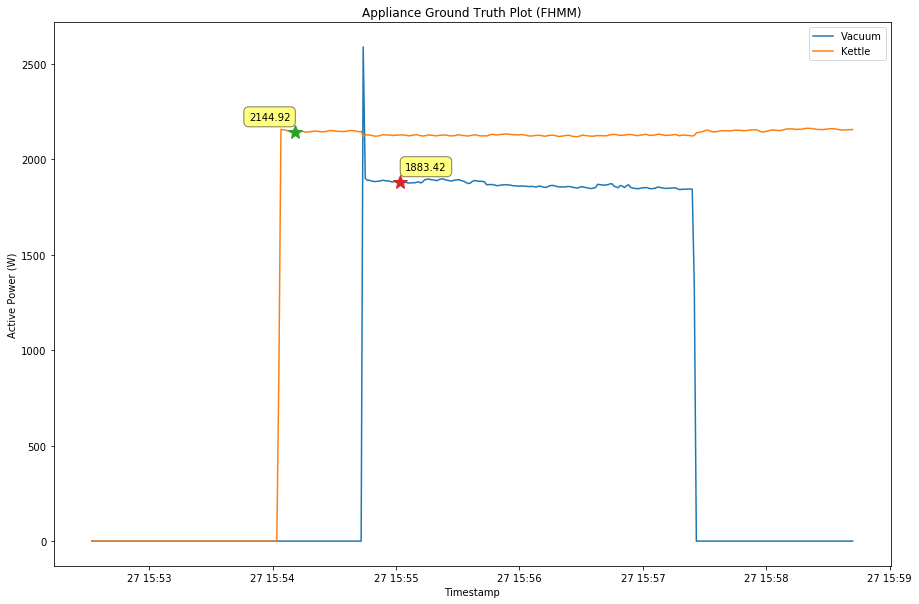

In [27]:
# Plot GT 
gt_vac = plt.plot(gt_overall.index, gt_overall['vacuum'], label = 'Vacuum')
gt_ke = plt.plot(gt_overall.index, gt_overall['kettle'], label = 'Kettle')
point1 = plt.plot(x_ke[0],ke_ss,marker="*",markersize=15)
point2 = plt.plot(x_vac[0],vac_ss,marker="*",markersize=15)

plt.title("Appliance Ground Truth Plot (FHMM)")
plt.legend()
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

# annotate kettle point
plt.annotate(
        ke_ss, 
        xy = (x_ke[0], ke_ss), xytext = (-5, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate vacuum point
plt.annotate(
        vac_ss, 
        xy = (x_vac[0], vac_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))

## Predicted

In [28]:
# Get steady state points to plot
x=pred_overall.index
ke_val = pred_overall['kettle'].values
vac_val = pred_overall['vacuum'].values

# Kettle steady state point
ke_ss = pred_overall.iloc[100]['kettle']
x_ke = np.where(ke_val==ke_ss)
x_ke = x[x_ke]

# Vacuum steady state point
vac_ss = pred_overall.iloc[150]['vacuum']
x_vac = np.where(vac_val==vac_ss)
x_vac = x[x_vac]

Text(5, 10, '1933.0')

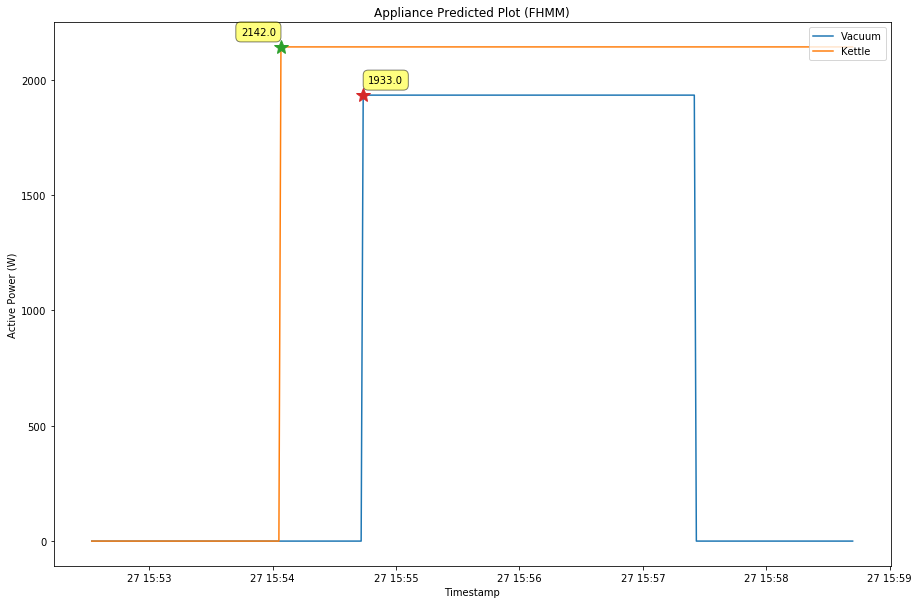

In [29]:
# Plot Predicted 
pred_vac = plt.plot(pred_overall.index, pred_overall['vacuum'], label = 'Vacuum')
pred_ke = plt.plot(pred_overall.index, pred_overall['kettle'], label = 'Kettle')
point1 = plt.plot(x_ke[0],ke_ss,marker="*",markersize=15)
point2 = plt.plot(x_vac[0],vac_ss,marker="*",markersize=15)

plt.title("Appliance Predicted Plot (FHMM)")
plt.legend(loc=1)
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

# annotate kettle point
plt.annotate(
        ke_ss, 
        xy = (x_ke[0], ke_ss), xytext = (-5, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate vacuum point
plt.annotate(
        vac_ss, 
        xy = (x_vac[0], vac_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))

## Main vs Predicted

Text(5, 10, '1933.0')

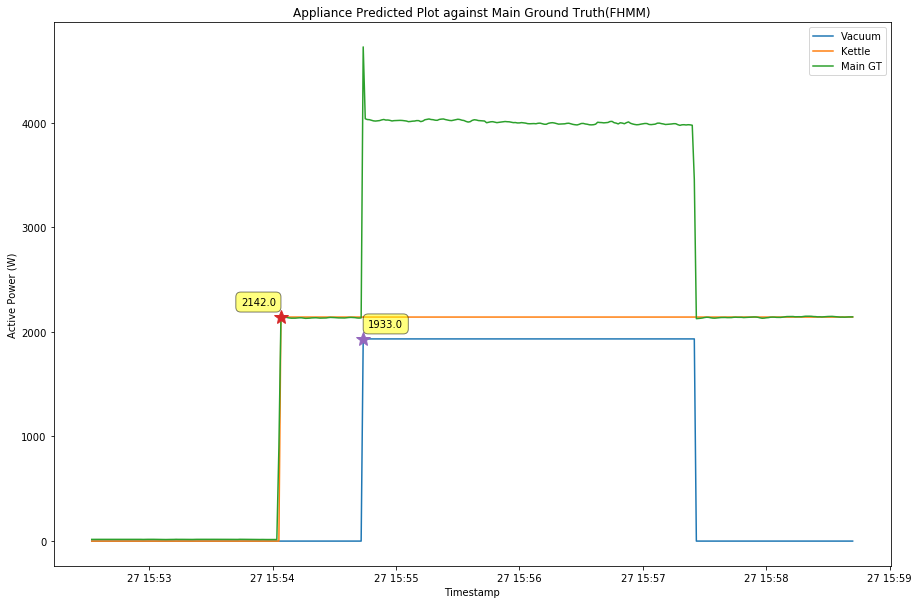

In [30]:
# Plot Predicted vs GT Main
pred_vac = plt.plot(pred_overall.index, pred_overall['vacuum'], label = 'Vacuum')
pred_ke = plt.plot(pred_overall.index, pred_overall['kettle'], label = 'Kettle')
pred_main = plt.plot(df_main, label = 'Main GT')
point1 = plt.plot(x_ke[0],ke_ss,marker="*",markersize=15)
point2 = plt.plot(x_vac[0],vac_ss,marker="*",markersize=15)

plt.title("Appliance Predicted Plot against Main Ground Truth(FHMM)")
plt.legend(loc=1)
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

# annotate kettle point
plt.annotate(
        ke_ss, 
        xy = (x_ke[0], ke_ss), xytext = (-5, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate vacuum point
plt.annotate(
        vac_ss, 
        xy = (x_vac[0], vac_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))

## Ground vs Predicted

Text(0.5, 0, 'Timestamp')

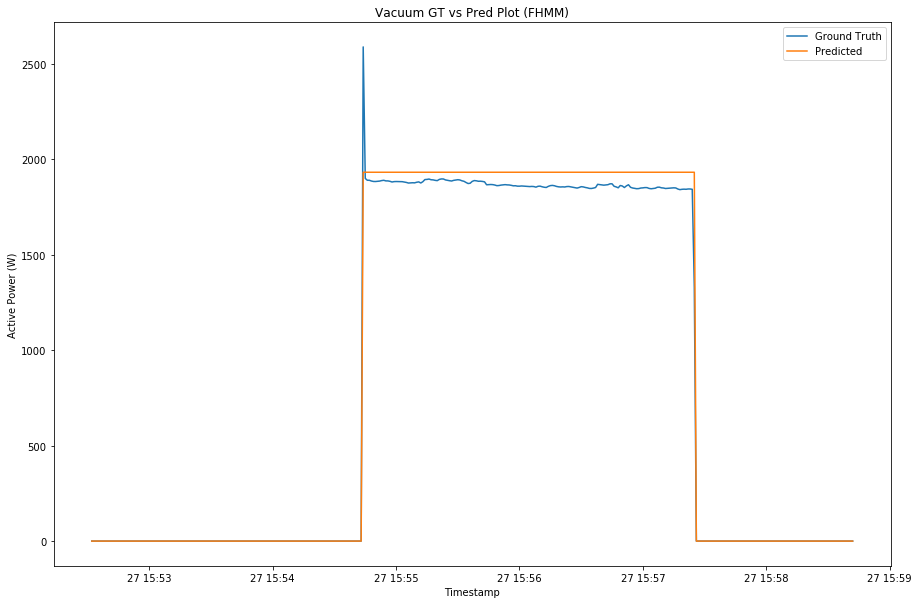

In [31]:
# Plot Vacuum
gt_vac = plt.plot(gt_overall.index, gt_overall['vacuum'], label = 'Ground Truth')
pred_vac = plt.plot(pred_overall.index, pred_overall['vacuum'], label = 'Predicted')

plt.title("Vacuum GT vs Pred Plot (FHMM)")
plt.legend()
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

Text(0.5, 0, 'Timestamp')

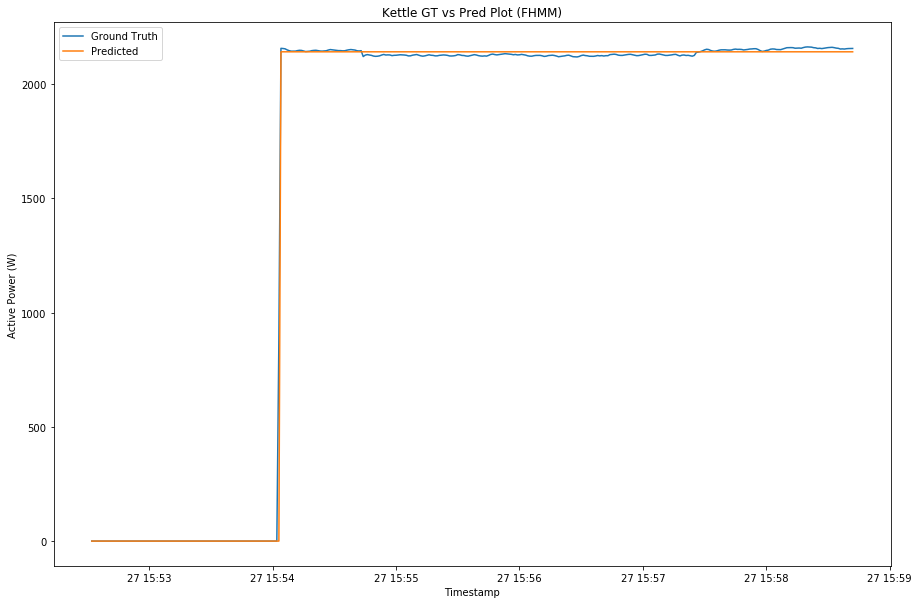

In [32]:
# Plot Kettle
gt_ke = plt.plot(gt_overall.index, gt_overall['kettle'], label = 'Ground Truth')
pred_ke = plt.plot(pred_overall.index, pred_overall['kettle'], label = 'Predicted')

plt.title("Kettle GT vs Pred Plot (FHMM)")
plt.legend()
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

# Evaluation Metrics
- Evaluations metrics are used to evaluate how well the prediction is done by the trained model.
- The predicted disaggregated load(s) are evaluated using a few evaluation metrics for regression loss:
    1. **MSE**
    2. **RMSE**
    3. **MAE**
    4. **MAPE**
- Computed results shows the error/loss values of predicted to ground truth
    - The pair with the least loss is considered the closest prediction or the more accurate prediction to ground truth
    
1. **Mean Squared Error (MSE)**
    - The mean squared error (MSE) tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. It’s called the mean squared error as you’re finding the average of a set of errors. The lower the MSE, the better the prediction.
     
2. **Root Mean Squared Error (RMSE)**
    - Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.
    
3. **Mean absolute error (MAE)**
    - Computes the mean of squares of errors between labeled data and predicted data. It calculates the absolute difference between the current output and the expected output divided by the number of output.
    
4. **Mean absolute percentage error (MAPE)**
    - is a measure of prediction accuracy of a forecasting method in statistics. It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values.

In [33]:
def rmse(gt,pred):
    val = np.sqrt(mean_squared_error(gt,pred))
    return val

In [34]:
metrics = [mean_squared_error, rmse, mean_absolute_error, mean_absolute_percentage_error]
metrics_label = ['MSE','RMSE' ,'MAE', 'MAPE']

# Show metrics
for metric,lbl in zip(metrics,metrics_label):
    try:
        loss_function = metric
    except:
        print ("Loss function ",metric, " is not supported currently!")
        continue

    error = {}
    for app_name in gt_overall.columns:
        error[app_name] = loss_function(gt_overall[app_name],pred_overall[app_name])
    
    error = pd.Series(error)
    computed_metric = pd.DataFrame(error)
    print("............ " ,lbl," ..............")
    print(computed_metric.to_string(header=False))
    print("\n")

............  MSE  ..............
kettle  2255.149902
vacuum  4090.820068


............  RMSE  ..............
kettle  47.488419
vacuum  63.959518


............  MAE  ..............
kettle  12.236386
vacuum  31.525986


............  MAPE  ..............
kettle  0.007310
vacuum  0.022391




# Conclusion
- Train: kettle+vacuum - 8 min data
- Test & disaggregate : kettle+vacuum 6 mins data

1. Able to detect the appliances correctly
2. Able to disaggregate kettle and vacuum load well

- Expected: Able to classify the appliances properly
- Result: Able to disaggregate well for kettle but has some outliers for vacuum spike in power